<a href="https://colab.research.google.com/github/daryaami/Image_classification_Natalie_Portman_Keira_Knightley/blob/main/V2_Natalie_Keira_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация фото Натали Портман и Киры Найтли

Задача, которую вы решали в этом проекте, заключается в классификации изображений лиц двух известных актрис (Киры Найтли и Натали Портман) с использованием технологий обработки изображений и глубокого обучения.

Многие люди считают, что Кира Найтли и Натали Портман очень похожи, что породило множество шуток и мемов о том, как их легко спутать. Вдохновленные этой популярной темой, мы решили разработать нейросеть, которая будет классифицировать изображения их лиц. Хотя задача не имеет практической значимости, она стала интересным и увлекательным примером применения технологий глубокого обучения для решения шуточной задачи.

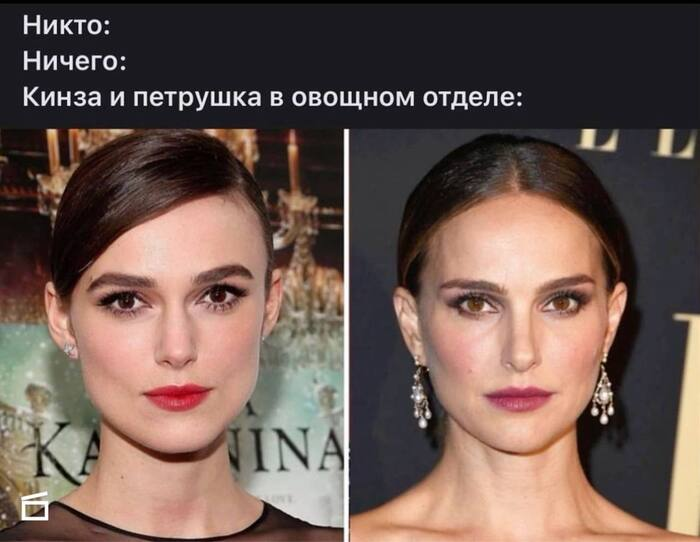

Для решения задачи был реализован пайплайн, включающий следующие этапы:

1. **Детекция лиц:** С использованием модели MTCNN проводилась детекция лиц на изображениях. Лица на изображениях вырезались для дальнейшей обработки.  


2. **Предобработка изображений:** Вырезанные лица были подвергнуты преобразованиям, включая изменение размера, нормализацию и преобразование в тензоры, что соответствовало требованиям для подачи данных в нейронную сеть. Для баланса классов в датасете была реализована аугментация данных.


3. **Обучение модели:** Для классификации изображений использовалась сверточная нейронная сеть (Xception), которая была в два этапа дообучена на датасете изображений лиц актрис. На первом этапе последний слой модели заменили на последовательность из нескольких новых слоев, подходящих под задачу, остальные слои были заморожены, чтобы не потерять их способность извлекать признаки. На втором этапе мы постарались повысить точность, разморозив все слои, и обучив модель несколько эпох на низком learning rate.


4. **Оценка модели:** В процессе обучения модели проводился тест на тестовом наборе данных, чтобы оценить ее эффективность в классификации изображений. Для улучшения результатов сохранялись все модели с наибольшей точностью.

5. **Инференс на новых данных:** Разработанная модель была протестирована на новых изображениях, где, после выделения лица, модель классифицировала его как одно из двух классов: 'Keira Knightley' или 'Natalie Portman'.

Датасет был собран с сайта https://www.theplace.ru/photos  
Как происходил парсинг датасета можно посмотреть [в этом блокноте](https://colab.research.google.com/drive/1No62t2pvzNXmaMl2RLbAwENZYSyoHRas?usp=sharing).

In [ ]:
%%capture
!pip install facenet-pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data import random_split
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet34_Weights
from torchvision.models import ResNet50_Weights

from facenet_pytorch import MTCNN

In [ ]:
base_dir = '/content/drive/MyDrive/projects/natalie_keira'
dir_path = os.path.join(base_dir, 'dataset')
cropped_dir = os.path.join(base_dir, 'cropped_qual')

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import numpy as np
import random

random_state = 33

torch.manual_seed(random_state)
np.random.seed(random_state)
random.seed(random_state)

## Детекция лиц

In [ ]:
from tqdm import tqdm
from PIL import ImageFilter

min_resolution = 48

mtcnn = MTCNN(keep_all=True, device=device)
os.makedirs(cropped_dir, exist_ok=True)

for class_name in os.listdir(dir_path):
    missed_total = 0
    class_path = os.path.join(dir_path, class_name)

    if os.path.isdir(class_path):
        class_cropped_dir = os.path.join(cropped_dir, class_name)
        os.makedirs(class_cropped_dir, exist_ok=True)

        # Список файлов для обработки
        file_list = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Обработка класса {class_name}: {len(file_list)} файлов...")

        for file_name in tqdm(file_list, desc=f"Класс {class_name}", unit="файл"):
            file_path = os.path.join(class_path, file_name)

            dest_file_path = os.path.join(class_cropped_dir, f'{file_name.split(".")[0]}_{i+1}.jpg')
            if not os.path.exists(dest_file_path):
                try:
                    image = Image.open(file_path)
                    boxes, _ = mtcnn.detect(image)

                    if boxes is not None and len(boxes) == 1:
                        for i, box in enumerate(boxes):
                            cropped_face = image.crop(box)

                            if cropped_face.size[0] < min_resolution or cropped_face.size[1] < min_resolution:
                                missed_total += 1
                                continue

                            cropped_face.save(dest_file_path)
                    else:
                        missed_total += 1

                except Exception as e:
                    tqdm.write(f"\nОшибка при обработке файла {file_path}: {e}")

        print(f'\nПропущено {missed_total} фото для класса {class_name}')


Обработка класса keira_knightley: 2482 файлов...


Класс keira_knightley: 100%|██████████| 2482/2482 [04:04<00:00, 10.16файл/s]



Пропущено 1800 фото для класса keira_knightley
Обработка класса natalie_portman: 2297 файлов...


Класс natalie_portman: 100%|██████████| 2297/2297 [02:56<00:00, 13.01файл/s]


Пропущено 1275 фото для класса natalie_portman


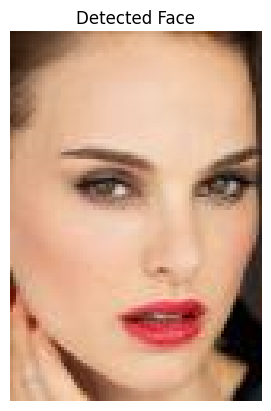

In [ ]:
image = Image.open('/content/drive/MyDrive/projects/natalie_keira/cropped_qual/natalie_portman/natalie1101_1.jpg')

plt.imshow(image)
plt.axis('off')
plt.title("Detected Face")
plt.show()

## Подготовка датасета

In [ ]:
def calculate_mean_std(dataset):
    """
    Функция для вычисления mean и std для датасета изображений.
    :param dataset: Датасет, по которому нужно посчитать статистику.
    :return: mean, std
    """
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_pixels = 0

    for img, _ in tqdm(dataset):
        img = transforms.ToTensor()(img)
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
        total_pixels += 1

    mean /= total_pixels
    std /= total_pixels

    return mean, std

In [ ]:
# mean, std = calculate_mean_std(datasets.ImageFolder(root=cropped_dir))
mean, std = torch.tensor([0.6318, 0.4896, 0.4238]), torch.tensor([0.2286, 0.2082, 0.1961])

In [ ]:
image_size = (128, 128)
batch_size = 128

In [ ]:
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # Случайное изменение цвета
    transforms.Resize(image_size),  # Изменяем размер изображений
    transforms.ToTensor(),         # Преобразуем в тензор
    transforms.Normalize(mean=mean, std=std)  # Нормализация
])

In [ ]:
dataset = datasets.ImageFolder(root=cropped_dir, transform=transform)

In [ ]:
from collections import Counter
class_counts = Counter([item[1] for item in dataset.imgs])

for class_name, count in class_counts.items():
    print(f"Class: {dataset.classes[class_name]}, Count: {count}")

Class: keira_knightley, Count: 682
Class: natalie_portman, Count: 1022


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

data_indices = list(range(len(dataset)))
data_labels = [dataset.targets[idx] for idx in data_indices]

train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    data_indices, data_labels, test_size=0.2, stratify=data_labels, random_state=random_state
)
test_indices, vis_indices, test_labels, vis_labels = train_test_split(
    temp_indices, temp_labels, test_size=0.04, stratify=temp_labels, random_state=random_state
)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
vis_dataset = Subset(dataset, vis_indices)

train_labels_only = [dataset.targets[idx] for idx in train_indices]
class_counts = Counter(train_labels_only)
print("Количество изображений в классах (train):", class_counts)

total_samples = len(train_labels_only)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Преобразование весов в список для каждого образца
sample_weights = [class_weights[label] for label in train_labels_only]

# Создание WeightedRandomSampler
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
vis_loader = DataLoader(vis_dataset, batch_size=1, shuffle=False)

# Проверка
print("Классы:", dataset.classes)  # Например: ['keira_knightley', 'natalie_portman']
print("Веса классов (train):", class_weights)

Количество изображений в классах (train): Counter({1: 817, 0: 546})
Классы: ['keira_knightley', 'natalie_portman']
Веса классов (train): {1: 1.6682986536107711, 0: 2.4963369963369964}


### Over-sampling для баланса классов

In [ ]:
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# import os
# from sklearn.model_selection import train_test_split
# from torchvision import transforms
# from torch.utils.data import DataLoader, Dataset

# Аугментации для синтеза данных
# augmentation_transform = transforms.Compose([
#     transforms.RandomRotation(degrees=15),
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.Resize(image_size)
# ])

# Создание синтезированных данных
# def generate_synthetic_data(dataset, target_class, target_count, save_dir):
#     os.makedirs(os.path.join(save_dir, target_class), exist_ok=True)
#     class_index = dataset.classes.index(target_class)
#     class_images = [img for img, label in dataset.imgs if label == class_index]
#     current_count = len(class_images)
#     additional_count = target_count - current_count

#     print(f"Generating {additional_count} synthetic images for class '{target_class}'...")

#     for i in tqdm(range(additional_count)):
#         img_path = random.choice(class_images)  # Случайно выбираем изображение
#         img = Image.open(img_path).convert("RGB")
#         augmented_img = augmentation_transform(img)  # Применяем аугментации
#         save_path = os.path.join(save_dir, target_class, f"{target_class}_synthetic_{i}.jpg")
#         augmented_img.save(save_path)

# Путь для сохранения синтезированных данных
# synthetic_dir = os.path.join(base_dir, 'synthetic_data')
# generate_synthetic_data(dataset, target_class="keira_knightley", target_count=1022, save_dir=synthetic_dir)

In [ ]:
# import shutil

# Путь для новой папки, которая будет содержать как исходные, так и синтезированные изображения
# combined_dir = os.path.join(base_dir, "combined_data")
# os.makedirs(combined_dir, exist_ok=True)

# Копируем изображения из исходной папки
# for class_name in dataset.classes:
#     class_folder = os.path.join(cropped_dir, class_name)
#     target_folder = os.path.join(combined_dir, class_name)
#     os.makedirs(target_folder, exist_ok=True)
#     for img_name in os.listdir(class_folder):
#         img_path = os.path.join(class_folder, img_name)
#         shutil.copy(img_path, target_folder)

# Копируем синтезированные изображения
# for class_name in ["keira_knightley", "natalie_portman"]:
#     class_folder = os.path.join(synthetic_dir, class_name)
#     os.makedirs(class_folder, exist_ok=True)
#     target_folder = os.path.join(combined_dir, class_name)
#     for img_name in os.listdir(class_folder):
#         img_path = os.path.join(class_folder, img_name)
#         shutil.copy(img_path, target_folder)

# # Добавляем синтезированные данные в ImageFolder
# final_dataset = datasets.ImageFolder(root=combined_dir, transform=transform)
# print(len(final_dataset.imgs))

In [ ]:
# train_ratio = 0.8
# vis_ratio = 0.01
# test_ratio = 1 - train_ratio - vis_ratio

# train_dataset, test_dataset, vis_dataset = random_split(final_dataset, [train_ratio, test_ratio, vis_ratio])

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# vis_loader = DataLoader(vis_dataset, batch_size=1, shuffle=False)

### Визуализируем несколько обработанных изображений из датасета

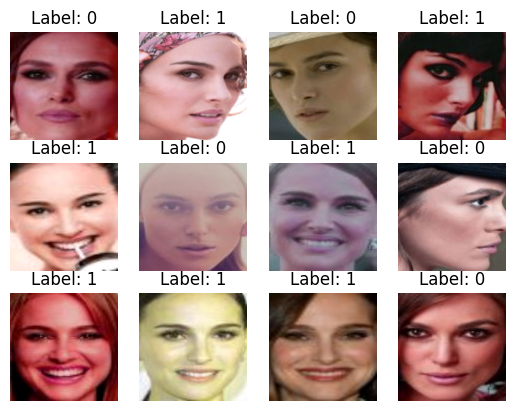

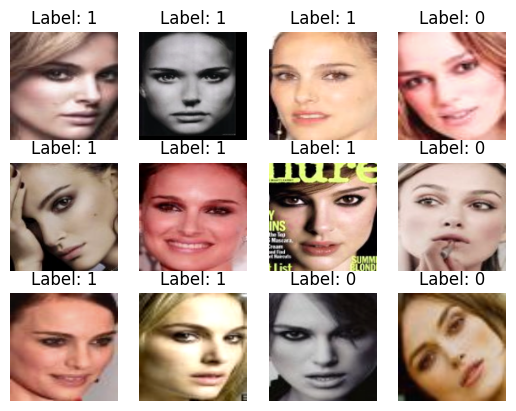

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Функция для денормализации
def denormalize(tensor):
    for c in range(tensor.shape[0]):
        tensor[c].mul_(std[c]).add_(mean[c])
    tensor = tensor.clamp(0, 1)
    return tensor

batches = 2
n_batch = 1

for images, labels in train_loader:
    for i in range(min(12, len(images))):
        img = images[i]
        img = denormalize(img)
        img_pil = F.to_pil_image(img)
        label = labels[i]
        plt.subplot(3, 4, i + 1)
        plt.imshow(img_pil)
        plt.title(f"Label: {label.item()}")
        plt.axis("off")
    plt.show()
    n_batch += 1
    if n_batch > batches:
        break

## Обучение модели

Используемая модель - [Xception](https://pprp.github.io/timm/models/xception/).  
Xception — это архитектура сверточной нейронной сети, которая опирается исключительно на Depthwise Separable Convolutions.


In [ ]:
num_epochs = 32
learning_rate = 0.001
num_classes = 2

In [ ]:
import timm

class ModifiedXception(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedXception, self).__init__()
        self.model = timm.create_model('legacy_xception', pretrained=True)

        self.features = nn.Sequential(*list(self.model.children())[:-1])

        self.additional_fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.additional_fc(x)
        return x

In [ ]:
model = ModifiedXception(num_classes=num_classes)

for param in model.parameters():
    param.requires_grad = False

for param in model.additional_fc.parameters():
    param.requires_grad = True

input_data = torch.randn(1, 3, 128, 128)
output = model(input_data)
print(output.shape)

model = model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

torch.Size([1, 2])


In [ ]:
def evaluate(model, test_loader, device):
    """Оценка модели на тестовых данных"""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [ ]:
best_accuracy = 0
patience = np.inf
no_improvement_count = 0

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    test_accuracy = evaluate(model, test_loader, device)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.2f}%, Test Accuracy: {test_accuracies[-1]:.2f}%")

    if test_accuracy > best_accuracy:
        print(f"Improved accuracy! Saving model...")
        best_accuracy = test_accuracy
        if test_accuracy > 78:
            torch.save(model.state_dict(), f'best_model_ep{epoch+1}_{test_accuracy:.2f}.pth')
        no_improvement_count = 0
    else:
        if test_accuracy > 78:
            torch.save(model.state_dict(), f'model_ep{epoch+1}_{test_accuracy:.2f}.pth')
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f"No improvement for {patience} epochs. Stopping training early.")
        break

Epoch 1/32: 100%|██████████| 13/13 [00:11<00:00,  1.11batch/s]


Epoch [1/32], Loss: 0.7320, Train Accuracy: 55.62%, Test Accuracy: 61.08%
Improved accuracy! Saving model...


Epoch 2/32: 100%|██████████| 13/13 [00:11<00:00,  1.10batch/s]


Epoch [2/32], Loss: 0.6330, Train Accuracy: 70.54%, Test Accuracy: 70.10%
Improved accuracy! Saving model...


Epoch 3/32: 100%|██████████| 13/13 [00:11<00:00,  1.11batch/s]


Epoch [3/32], Loss: 0.5818, Train Accuracy: 75.67%, Test Accuracy: 75.00%
Improved accuracy! Saving model...


Epoch 4/32: 100%|██████████| 13/13 [00:11<00:00,  1.14batch/s]


Epoch [4/32], Loss: 0.5724, Train Accuracy: 76.34%, Test Accuracy: 75.77%
Improved accuracy! Saving model...


Epoch 5/32: 100%|██████████| 13/13 [00:11<00:00,  1.15batch/s]


Epoch [5/32], Loss: 0.5981, Train Accuracy: 72.49%, Test Accuracy: 75.77%


Epoch 6/32: 100%|██████████| 13/13 [00:11<00:00,  1.15batch/s]


Epoch [6/32], Loss: 0.5427, Train Accuracy: 77.93%, Test Accuracy: 75.00%


Epoch 7/32: 100%|██████████| 13/13 [00:11<00:00,  1.15batch/s]


Epoch [7/32], Loss: 0.5235, Train Accuracy: 79.65%, Test Accuracy: 70.62%


Epoch 8/32: 100%|██████████| 13/13 [00:11<00:00,  1.15batch/s]


Epoch [8/32], Loss: 0.5210, Train Accuracy: 79.52%, Test Accuracy: 79.12%
Improved accuracy! Saving model...


Epoch 9/32: 100%|██████████| 13/13 [00:11<00:00,  1.11batch/s]


Epoch [9/32], Loss: 0.4898, Train Accuracy: 81.23%, Test Accuracy: 78.35%


Epoch 10/32: 100%|██████████| 13/13 [00:11<00:00,  1.10batch/s]


Epoch [10/32], Loss: 0.4785, Train Accuracy: 83.37%, Test Accuracy: 71.65%


Epoch 11/32: 100%|██████████| 13/13 [00:11<00:00,  1.15batch/s]


Epoch [11/32], Loss: 0.4776, Train Accuracy: 83.19%, Test Accuracy: 76.80%


Epoch 12/32: 100%|██████████| 13/13 [00:11<00:00,  1.15batch/s]


Epoch [12/32], Loss: 0.5009, Train Accuracy: 81.85%, Test Accuracy: 79.38%
Improved accuracy! Saving model...


Epoch 13/32: 100%|██████████| 13/13 [00:11<00:00,  1.12batch/s]


Epoch [13/32], Loss: 0.4676, Train Accuracy: 82.95%, Test Accuracy: 75.52%


Epoch 14/32: 100%|██████████| 13/13 [00:11<00:00,  1.13batch/s]


Epoch [14/32], Loss: 0.4595, Train Accuracy: 83.68%, Test Accuracy: 81.70%
Improved accuracy! Saving model...


Epoch 15/32: 100%|██████████| 13/13 [00:11<00:00,  1.12batch/s]


Epoch [15/32], Loss: 0.4442, Train Accuracy: 85.88%, Test Accuracy: 81.44%


Epoch 16/32: 100%|██████████| 13/13 [00:11<00:00,  1.12batch/s]


Epoch [16/32], Loss: 0.4209, Train Accuracy: 87.47%, Test Accuracy: 82.22%
Improved accuracy! Saving model...


Epoch 17/32: 100%|██████████| 13/13 [00:11<00:00,  1.14batch/s]


Epoch [17/32], Loss: 0.4218, Train Accuracy: 86.80%, Test Accuracy: 80.15%


Epoch 18/32: 100%|██████████| 13/13 [00:11<00:00,  1.13batch/s]


Epoch [18/32], Loss: 0.4148, Train Accuracy: 87.84%, Test Accuracy: 76.29%


Epoch 19/32: 100%|██████████| 13/13 [00:11<00:00,  1.17batch/s]


Epoch [19/32], Loss: 0.4299, Train Accuracy: 86.74%, Test Accuracy: 81.70%


Epoch 20/32: 100%|██████████| 13/13 [00:11<00:00,  1.12batch/s]


Epoch [20/32], Loss: 0.3991, Train Accuracy: 88.94%, Test Accuracy: 80.67%


Epoch 21/32: 100%|██████████| 13/13 [00:11<00:00,  1.11batch/s]


Epoch [21/32], Loss: 0.3878, Train Accuracy: 89.30%, Test Accuracy: 81.96%


Epoch 22/32: 100%|██████████| 13/13 [00:11<00:00,  1.12batch/s]


Epoch [22/32], Loss: 0.4033, Train Accuracy: 88.63%, Test Accuracy: 84.54%
Improved accuracy! Saving model...


Epoch 23/32: 100%|██████████| 13/13 [00:11<00:00,  1.11batch/s]


Epoch [23/32], Loss: 0.3894, Train Accuracy: 89.85%, Test Accuracy: 82.47%


Epoch 24/32: 100%|██████████| 13/13 [00:11<00:00,  1.11batch/s]


Epoch [24/32], Loss: 0.3869, Train Accuracy: 89.85%, Test Accuracy: 79.64%


Epoch 25/32: 100%|██████████| 13/13 [00:11<00:00,  1.11batch/s]


Epoch [25/32], Loss: 0.3749, Train Accuracy: 90.22%, Test Accuracy: 81.70%


Epoch 26/32: 100%|██████████| 13/13 [00:11<00:00,  1.11batch/s]


Epoch [26/32], Loss: 0.3635, Train Accuracy: 91.63%, Test Accuracy: 83.76%


Epoch 27/32: 100%|██████████| 13/13 [00:11<00:00,  1.12batch/s]


Epoch [27/32], Loss: 0.3493, Train Accuracy: 92.85%, Test Accuracy: 79.38%


Epoch 28/32: 100%|██████████| 13/13 [00:11<00:00,  1.12batch/s]


Epoch [28/32], Loss: 0.3436, Train Accuracy: 93.46%, Test Accuracy: 80.41%


Epoch 29/32: 100%|██████████| 13/13 [00:11<00:00,  1.11batch/s]


Epoch [29/32], Loss: 0.3442, Train Accuracy: 92.91%, Test Accuracy: 80.41%


Epoch 30/32: 100%|██████████| 13/13 [00:11<00:00,  1.12batch/s]


Epoch [30/32], Loss: 0.3585, Train Accuracy: 91.99%, Test Accuracy: 79.12%


Epoch 31/32: 100%|██████████| 13/13 [00:11<00:00,  1.12batch/s]


Epoch [31/32], Loss: 0.3593, Train Accuracy: 91.63%, Test Accuracy: 83.76%


Epoch 32/32: 100%|██████████| 13/13 [00:11<00:00,  1.13batch/s]


Epoch [32/32], Loss: 0.3371, Train Accuracy: 93.52%, Test Accuracy: 83.76%


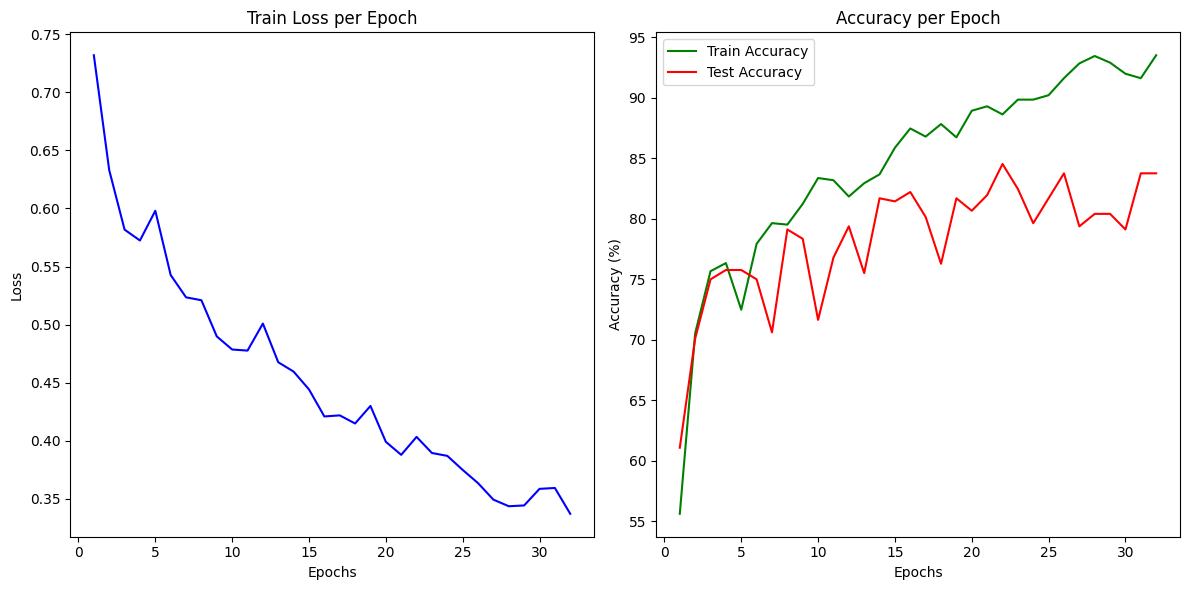

In [ ]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss per Epoch')

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", color='green')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Test Accuracy", color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Fine-tuning модели

In [ ]:
model_path = '/content/best_model_ep23_84.02.pth'

model = ModifiedXception(num_classes=num_classes)

model.load_state_dict(torch.load(model_path, weights_only=True))
model.to(device)
model.eval()
print(f"Model {model_path} loaded successfully")

for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.1, verbose=True)

Model /content/best_model_ep23_84.02.pth loaded successfully


In [ ]:
num_epochs = 7

best_accuracy = 0
patience = 3
no_improvement_count = 0

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    test_accuracy = evaluate(model, test_loader, device)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.2f}%, Test Accuracy: {test_accuracies[-1]:.2f}%")

    if test_accuracy > best_accuracy:
        print(f"Improved accuracy! Saving model...")
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), f'best_model_tunning_{test_accuracies[-1]:.2f}.pth')
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    scheduler.step(test_accuracy)

    if no_improvement_count >= patience:
        print(f"No improvement for {patience} epochs. Stopping training early.")
        break

Epoch 1/7: 100%|██████████| 11/11 [00:17<00:00,  1.59s/batch]


Epoch [1/7], Loss: 0.3998, Train Accuracy: 87.53%, Test Accuracy: 88.38%
Improved accuracy! Saving model...


Epoch 2/7: 100%|██████████| 11/11 [00:15<00:00,  1.42s/batch]


Epoch [2/7], Loss: 0.3557, Train Accuracy: 90.61%, Test Accuracy: 89.60%
Improved accuracy! Saving model...


Epoch 3/7: 100%|██████████| 11/11 [00:14<00:00,  1.29s/batch]


Epoch [3/7], Loss: 0.3444, Train Accuracy: 92.88%, Test Accuracy: 90.52%
Improved accuracy! Saving model...


Epoch 4/7: 100%|██████████| 11/11 [00:14<00:00,  1.35s/batch]


Epoch [4/7], Loss: 0.3153, Train Accuracy: 94.86%, Test Accuracy: 90.21%


Epoch 5/7: 100%|██████████| 11/11 [00:14<00:00,  1.28s/batch]


Epoch [5/7], Loss: 0.2950, Train Accuracy: 96.04%, Test Accuracy: 91.74%
Improved accuracy! Saving model...


Epoch 6/7: 100%|██████████| 11/11 [00:14<00:00,  1.33s/batch]


Epoch [6/7], Loss: 0.2825, Train Accuracy: 96.77%, Test Accuracy: 92.05%
Improved accuracy! Saving model...


Epoch 7/7: 100%|██████████| 11/11 [00:14<00:00,  1.29s/batch]


Epoch [7/7], Loss: 0.2794, Train Accuracy: 97.43%, Test Accuracy: 91.74%


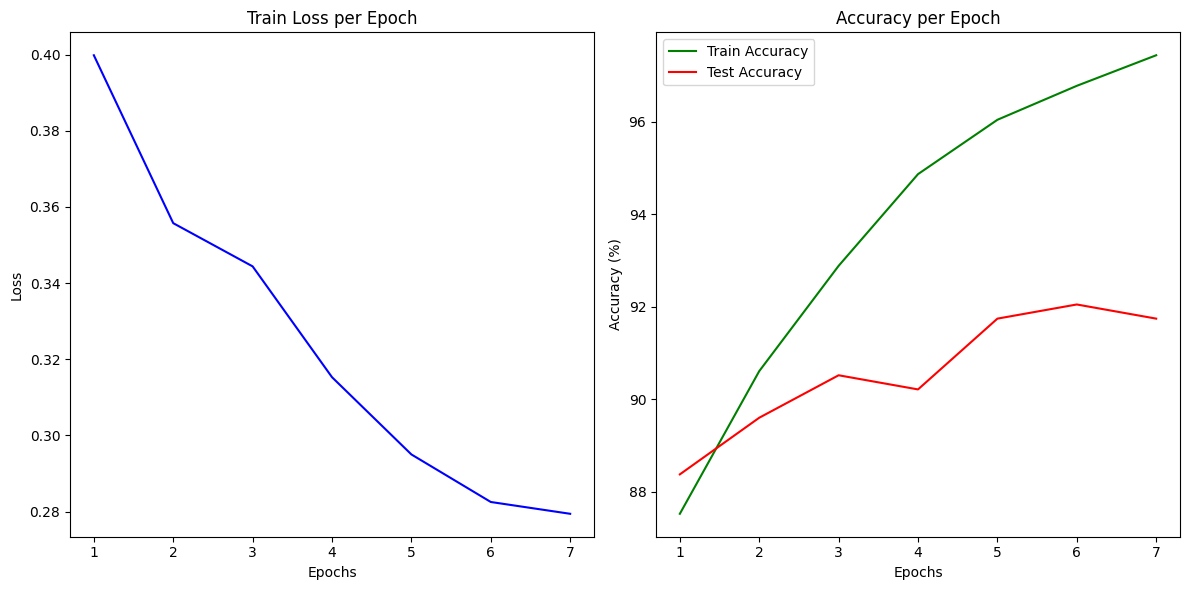

In [ ]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss per Epoch')

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", color='green')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Test Accuracy", color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Анализ ошибок

Загрузим лучшую модель из чекпоинтов.

In [ ]:
# model_path = '/content/best_model_ep23_84.02.pth'
model_path = '/content/best_model_tunning_92.05.pth'

model = ModifiedXception(num_classes=num_classes)

model.load_state_dict(torch.load(model_path, weights_only=True))
model.to(device)
model.eval()
print(f"Model {model_path} loaded successfully")

Model /content/best_model.pth loaded successfully


### Матрица ошибок

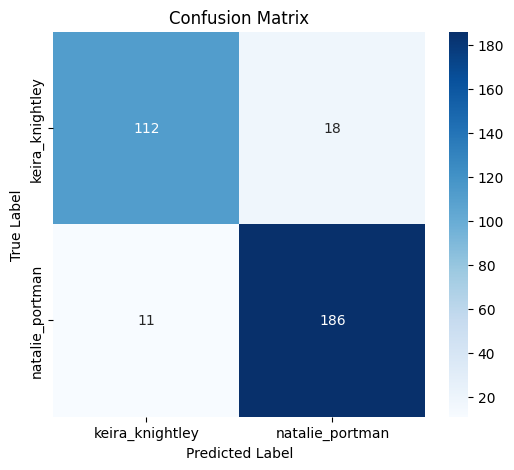

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(model, data_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = get_predictions(model, test_loader, device)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Классифицируем и визуализируем отложенный набор фото

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
def classify_image_tensor(image_tensor, model, device):
    """
    Функция для классификации одного изображения.
    :param image_tensor: Тензор изображения.
    :param model: Обученная модель.
    :param device: Устройство (CPU или GPU).
    :return: Метка класса (keira_knightley или natalie_portman).
    """
    model.eval()

    with torch.no_grad():
        input_tensor = image_tensor.unsqueeze(0).to(device)
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)

    class_label = 'keira_knightley' if predicted.item() == 0 else 'natalie_portman'

    return class_label

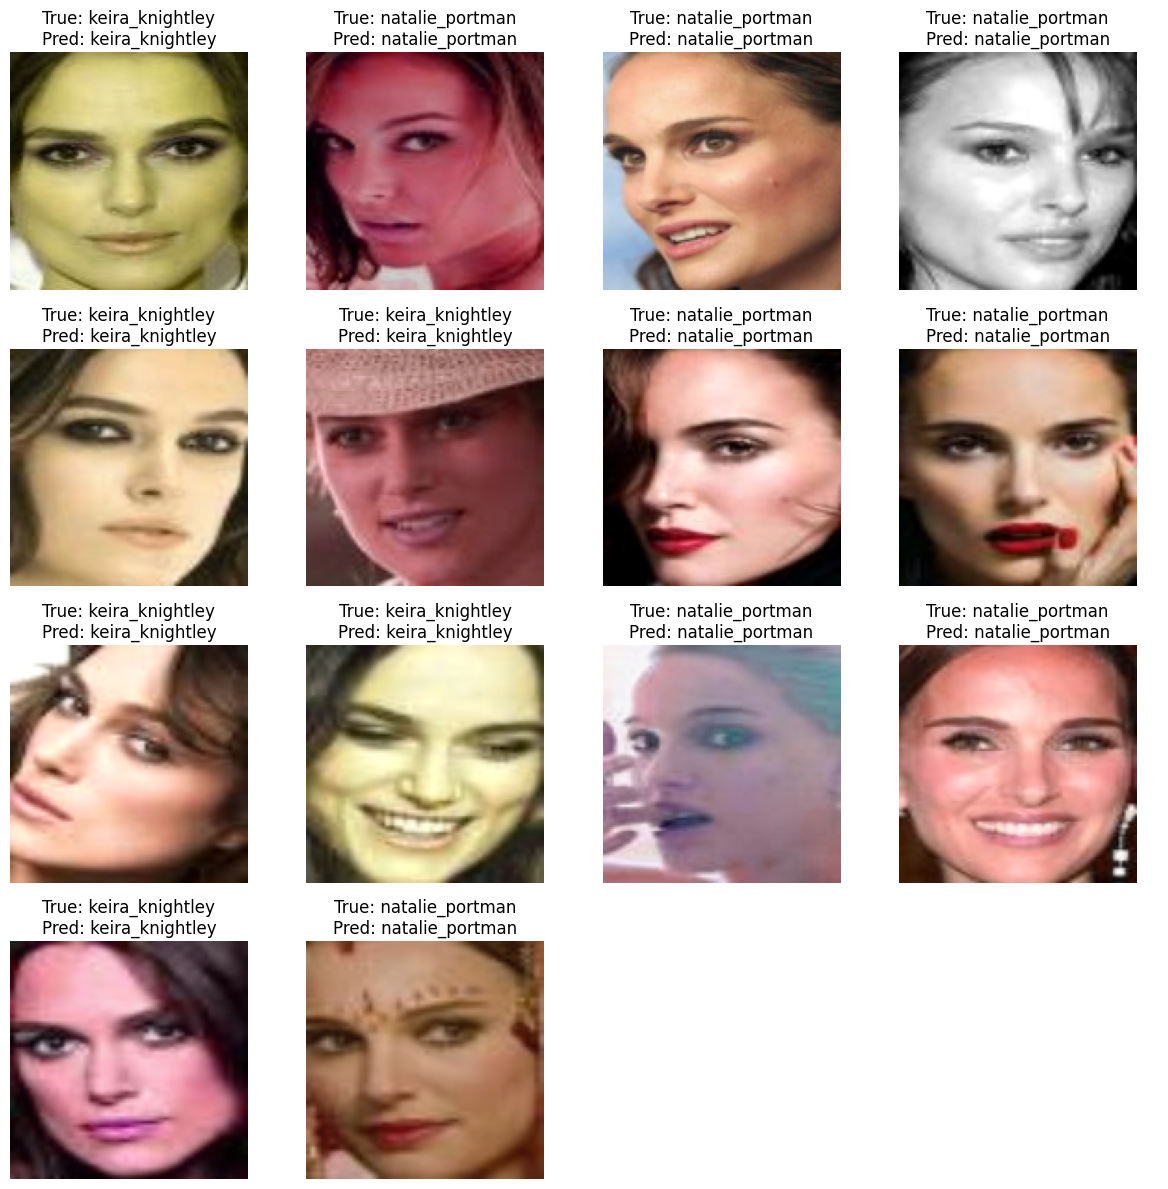

Нет изображений для отображения.


In [ ]:
def classify_validation_images(loader, model, device, classes):
    """
    Классификация всех изображений из валидационного набора, разделение на правильные и неправильные,
    и отображение их в виде сетки.
    :param loader: DataLoader для валидационного набора.
    :param model: Обученная модель.
    :param device: Устройство (CPU или GPU).
    :param classes: Список классов.
    """
    model.to(device)
    correct_images = []
    incorrect_images = []
    correct_labels = []
    incorrect_labels = []
    correct_predictions = []
    incorrect_predictions = []

    for image_tensors, label_tensors in loader:
        for image_tensor, label_tensor in zip(image_tensors, label_tensors):
            class_label = classify_image_tensor(image_tensor, model, device)
            predicted_label = class_label
            true_label = classes[label_tensor.item()]

            if predicted_label == true_label:
                correct_images.append(denormalize(image_tensor).permute(1, 2, 0).cpu().numpy())
                correct_labels.append(true_label)
                correct_predictions.append(predicted_label)
            else:
                incorrect_images.append(denormalize(image_tensor).permute(1, 2, 0).cpu().numpy())
                incorrect_labels.append(true_label)
                incorrect_predictions.append(predicted_label)

    if len(correct_images) > 0:
        num_images = len(correct_images)
        cols = 4
        rows = (num_images + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
        if rows == 1:
            axes = axes.reshape(1, -1)

        for i, ax in enumerate(axes.flat):
            if i < num_images:
                ax.imshow(correct_images[i])
                ax.axis('off')
                ax.set_title(f"True: {correct_labels[i]}\nPred: {correct_predictions[i]}")
            else:
                ax.axis('off')

        plt.tight_layout()
        plt.show()

    if len(incorrect_images) > 0:
        num_images = len(incorrect_images)
        cols = 4
        rows = (num_images + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
        if rows == 1:
            axes = axes.reshape(1, -1)

        for i, ax in enumerate(axes.flat):
            if i < num_images:
                ax.imshow(incorrect_images[i])
                ax.axis('off')
                ax.set_title(f"True: {incorrect_labels[i]}\nPred: {incorrect_predictions[i]}")
            else:
                ax.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Нет изображений для отображения.")

classify_validation_images(vis_loader, model, device, dataset.classes)

### Посмотрим, на каких изображениях из тестовой выборки модель справляется хорошо, а на каких ошибается

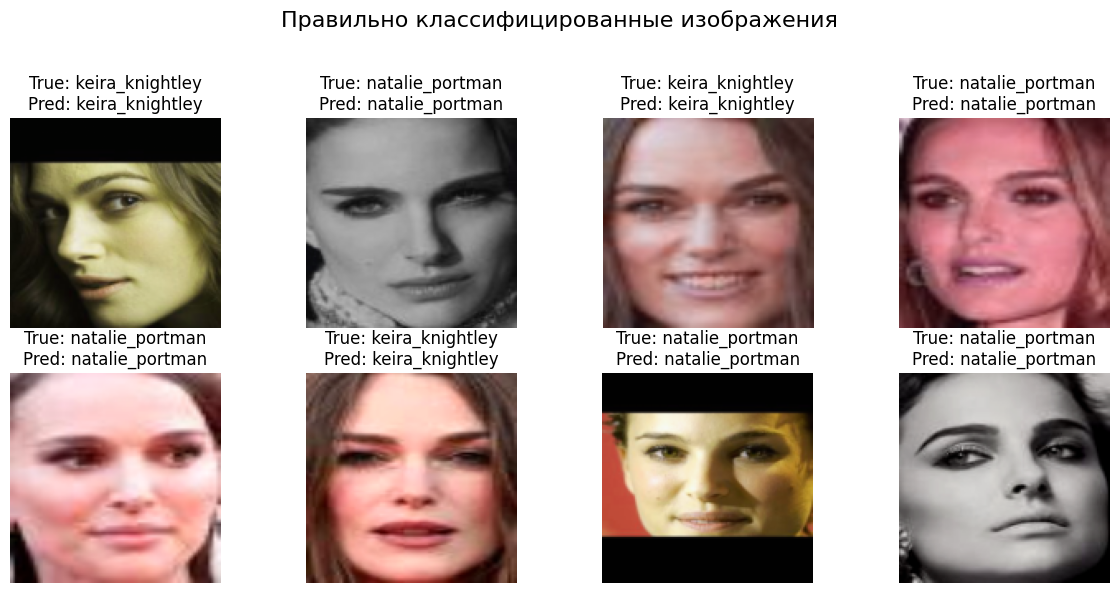

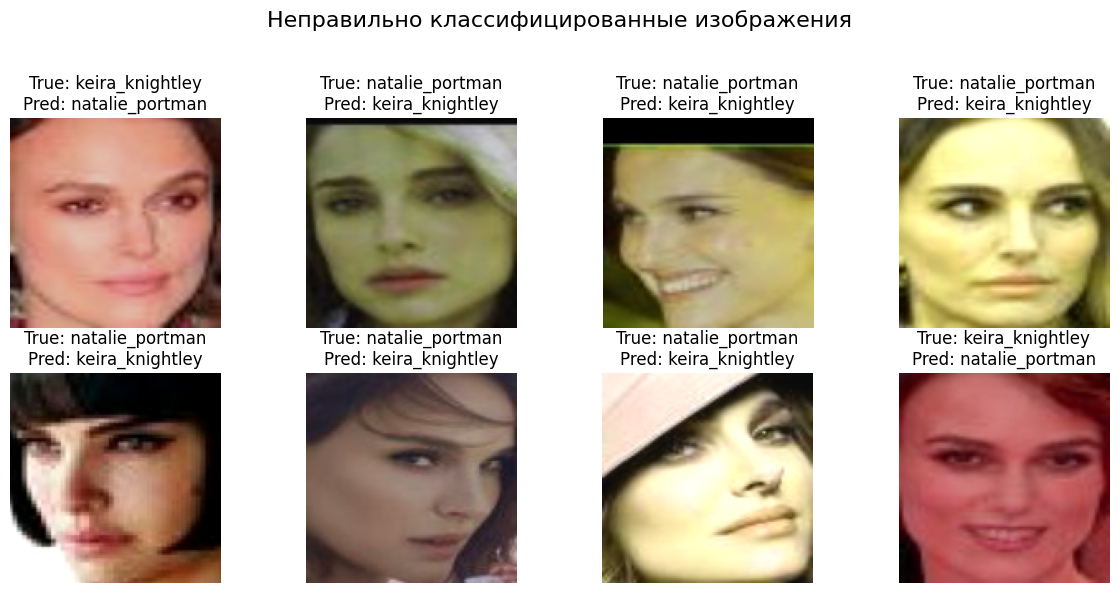

In [ ]:
def classify_test_images(loader, model, device, classes):
    """
    Классификация всех изображений из тестового набора, разделение на правильные и неправильные,
    и отображение их в виде двух отдельных сеток.
    :param loader: DataLoader для тестового набора.
    :param model: Обученная модель.
    :param device: Устройство (CPU или GPU).
    :param classes: Список классов.
    """
    model.to(device)
    correct_images = []
    incorrect_images = []
    correct_labels = []
    incorrect_labels = []
    correct_predictions = []
    incorrect_predictions = []

    max_images = 8

    for image_tensors, label_tensors in loader:
        if len(correct_images) >= max_images and len(incorrect_images) >= max_images:
            break

        for image_tensor, label_tensor in zip(image_tensors, label_tensors):
            class_label = classify_image_tensor(image_tensor, model, device)
            predicted_label = class_label
            true_label = classes[label_tensor.item()]

            if predicted_label == true_label and len(correct_images) < max_images:
                correct_images.append(denormalize(image_tensor).permute(1, 2, 0).cpu().numpy())
                correct_labels.append(true_label)
                correct_predictions.append(predicted_label)
            elif predicted_label != true_label and len(incorrect_images) < max_images:
                incorrect_images.append(denormalize(image_tensor).permute(1, 2, 0).cpu().numpy())
                incorrect_labels.append(true_label)
                incorrect_predictions.append(predicted_label)

    # Отображаем правильно классифицированные изображения
    if len(correct_images) > 0:
        num_images = len(correct_images)
        cols = 4
        rows = (num_images + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
        if rows == 1:
            axes = axes.reshape(1, -1)

        for i, ax in enumerate(axes.flat):
            if i < num_images:
                ax.imshow(correct_images[i])
                ax.axis('off')
                ax.set_title(f"True: {correct_labels[i]}\nPred: {correct_predictions[i]}")
            else:
                ax.axis('off')

        plt.tight_layout()
        plt.suptitle("Правильно классифицированные изображения", fontsize=16)
        plt.subplots_adjust(top=0.8)
        plt.show()

    # Отображаем неправильно классифицированные изображения
    if len(incorrect_images) > 0:
        num_images = len(incorrect_images)
        cols = 4
        rows = (num_images + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
        if rows == 1:
            axes = axes.reshape(1, -1)

        for i, ax in enumerate(axes.flat):
            if i < num_images:
                ax.imshow(incorrect_images[i])
                ax.axis('off')
                ax.set_title(f"True: {incorrect_labels[i]}\nPred: {incorrect_predictions[i]}")
            else:
                ax.axis('off')

        plt.tight_layout()
        plt.suptitle("Неправильно классифицированные изображения", fontsize=16)
        plt.subplots_adjust(top=0.8)
        plt.show()

    else:
        print("Нет изображений для отображения.")

classify_test_images(test_loader, model, device, dataset.classes)

## Тестируем модель на новых данных

In [ ]:
%%capture
!apt-get install -y fonts-dejavu-core
!fc-cache -fv

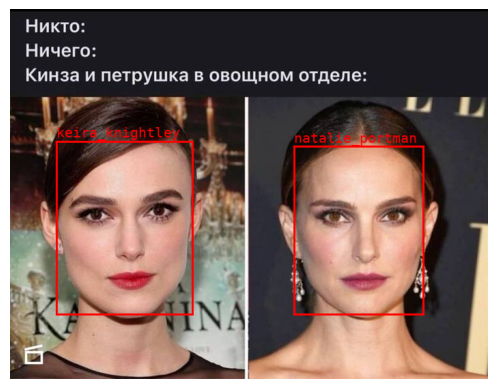

In [ ]:
from PIL import Image, ImageDraw, ImageFont

def annotate_image(image_path, model, mtcnn, transform):
    """
    Аннотирует изображение рамкой лица и меткой класса.
    :param image_path: Путь к изображению.
    :param model: Обученная модель для классификации.
    :param mtcnn: MTCNN для детекции лиц.
    :param transform: Трансформация для предобработки изображения.
    :return: Аннотированное изображение.
    """
    model.eval()
    image = Image.open(image_path)
    boxes, _ = mtcnn.detect(image)

    if boxes is not None:
        draw = ImageDraw.Draw(image)

        for box in boxes:
            face = image.crop(box)
            face_tensor = transform_test(face).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(face_tensor)
                _, predicted = torch.max(outputs, 1)
                class_index = predicted.item()
                class_name = dataset.classes[class_index]

            draw.rectangle(box.tolist(), outline="red", width=3)

            label = f"{class_name}"
            try:
                font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf", size=20)
            except OSError as e:
                print(f"Не удалось загрузить шрифт: {e}")
                font = ImageFont.load_default()
            draw.text((box[0], max(0, box[1] - 24)), label, fill="red", font=font)

    return image, class_name

mtcnn = MTCNN(keep_all=True, device=device)

annotated_image, _ = annotate_image(
    '/content/Без названия (3).png',
    model,
    mtcnn,
    transform_test
)

plt.axis('off')
plt.imshow(annotated_image)

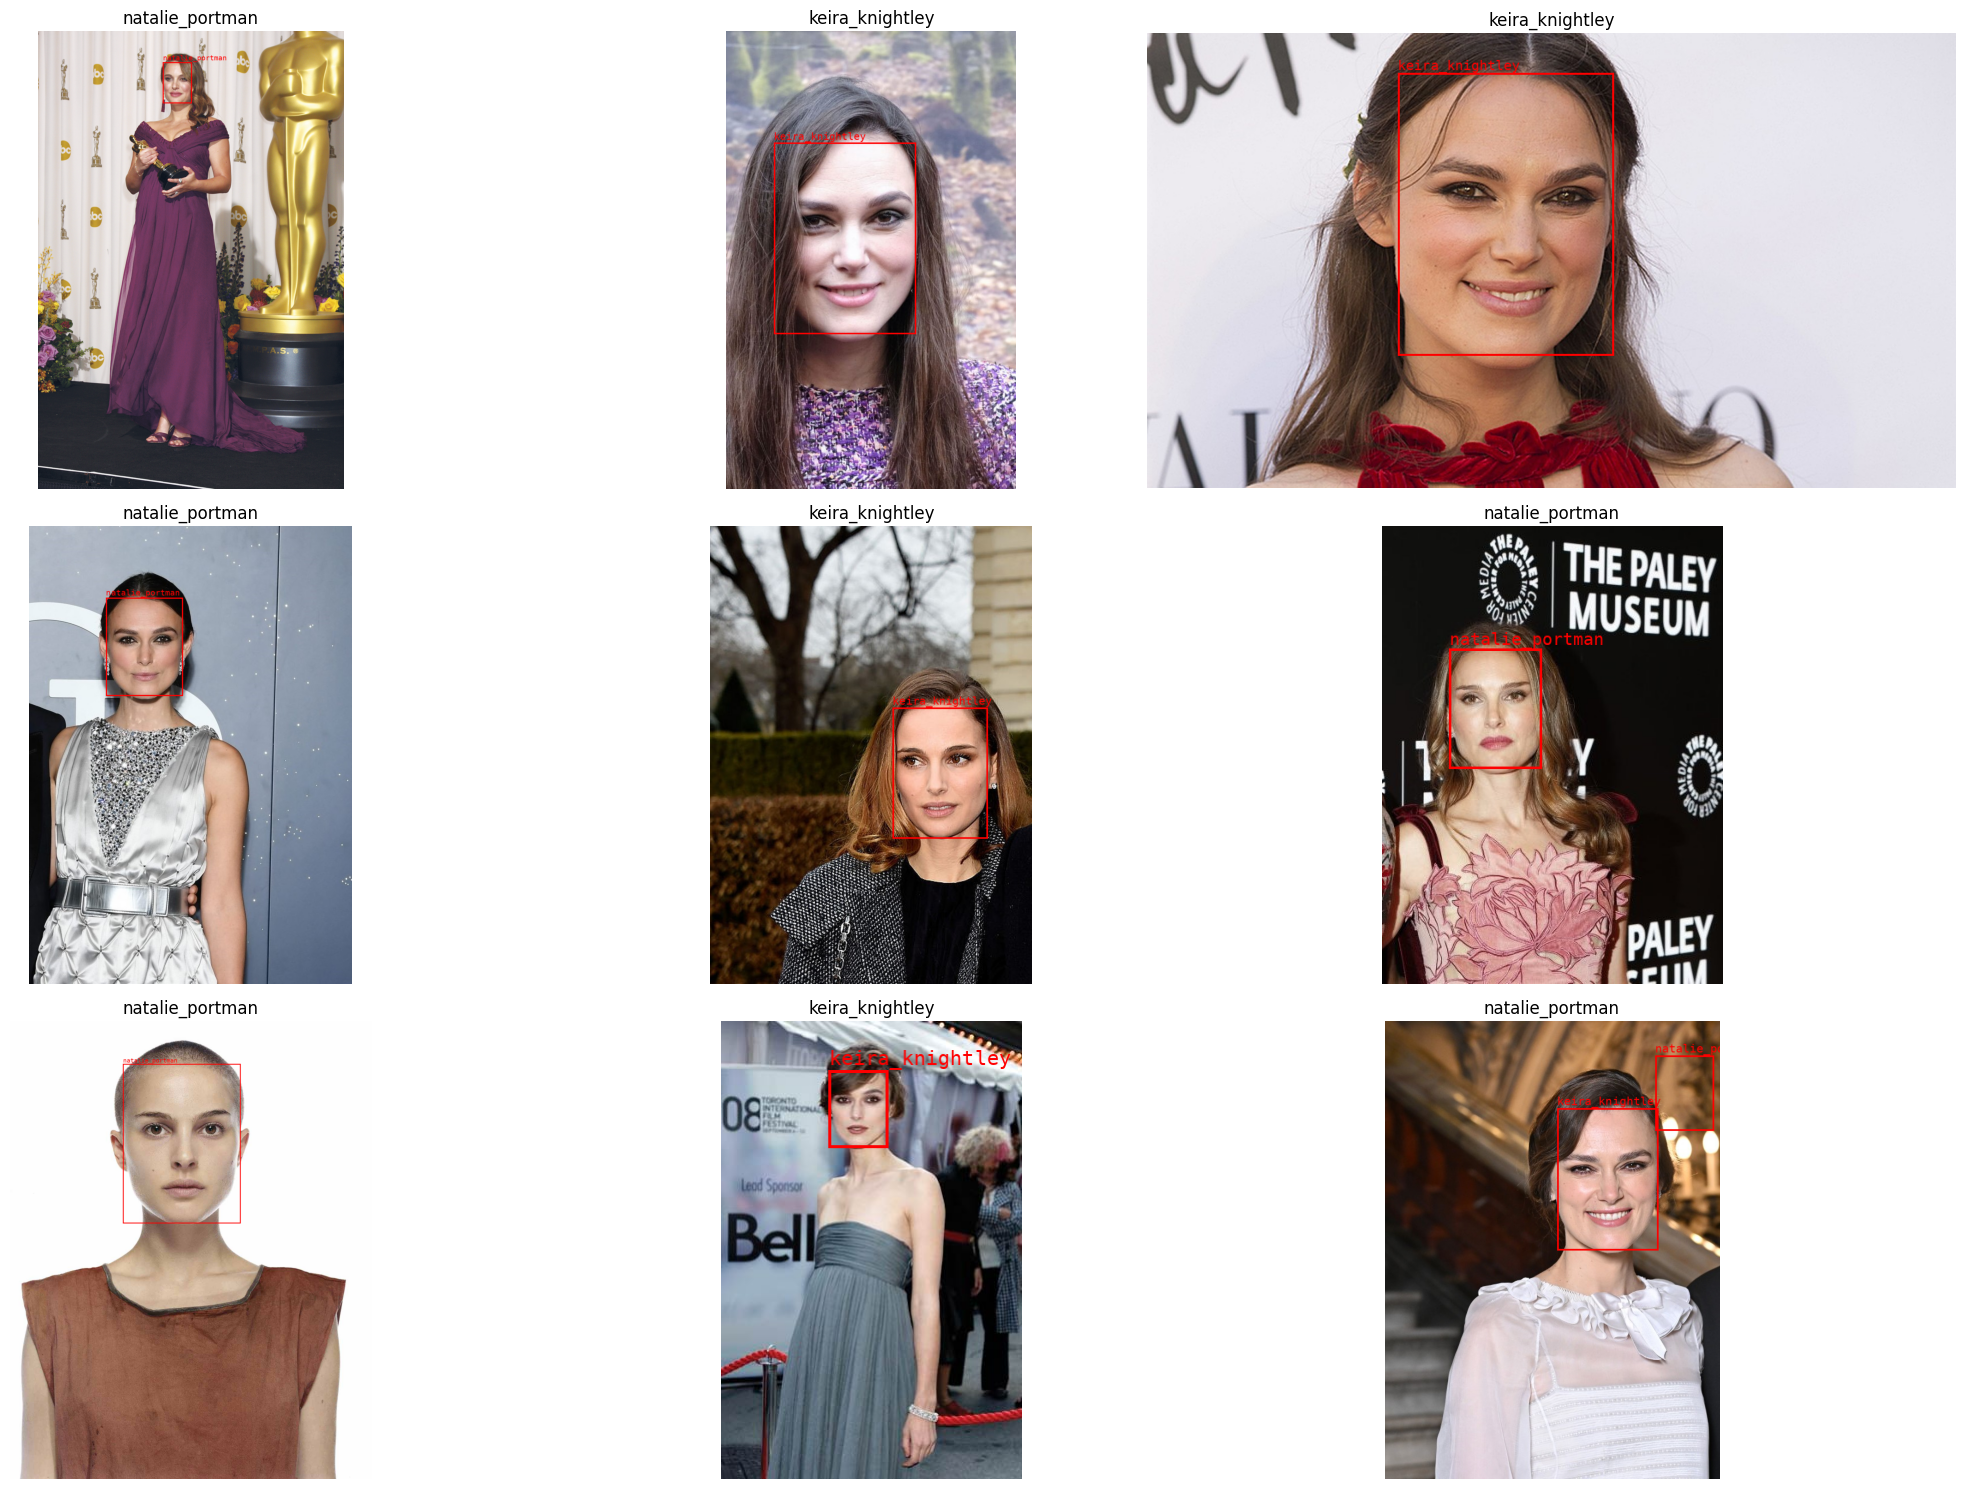

In [ ]:
from math import ceil

def annotate_and_display_from_folder(folder_path, model, mtcnn, transform, grid_size=(2, 2)):
    """
    Аннотирует и отображает изображения из папки в сетке.
    :param folder_path: Путь к папке с изображениями.
    :param model: Обученная модель для классификации.
    :param mtcnn: MTCNN для детекции лиц.
    :param transform: Трансформация для предобработки изображений.
    :param grid_size: Кортеж (rows, cols) для отображения сетки.
    """
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")
    image_paths = [
        os.path.join(folder_path, fname)
        for fname in os.listdir(folder_path)
        if fname.lower().endswith(image_extensions)
    ]

    if not image_paths:
        print(f"В папке {folder_path} нет изображений.")
        return

    num_images = len(image_paths)
    rows, cols = grid_size

    if rows * cols < num_images:
        rows = ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(22, 15))
    axes = axes.flatten()

    for i, image_path in enumerate(image_paths):
        annotated_image, class_name = annotate_image(image_path, model, mtcnn, transform)
        axes[i].imshow(annotated_image)
        axes[i].axis('off')
        axes[i].set_title(f"{class_name}")

    for i in range(len(image_paths), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


folder_path = '/content/drive/MyDrive/projects/natalie_keira/test_images'
annotate_and_display_from_folder(folder_path, model, mtcnn, transform_test, grid_size=(3, 3))